# Câu hỏi: Dựa vào mô tả về mức độ dễ đọc, thì có thể phân loại các mức độ như thế nào cho từng nhóm điểm?

Đọc dữ liệu

In [42]:
import pyarrow.parquet as pa
table = pa.read_table('metadata_en2.parquet')

In [43]:
import pandas as pd
import numpy as np
df = table.to_pandas()

In [44]:
df.head()

,title,creator,birthdate,deathdate,publisher,issued,rights,language,subjects,description,Index,download count
1,The Master Spirit,"Magnay, William, Sir",1855,1917,Project Gutenberg,2022-03-25,Public domain in the USA.,en,"[London (England) -- Fiction, Love stories, Ad...",[Reading ease score: 71.3 (7th grade). Fairly ...,67703,57
2,The Family on Wheels,"Oxley, J. Macdonald (James Macdonald)",1855,1907,Project Gutenberg,2017-11-05,Public domain in the USA.,en,"[Orphans -- Juvenile fiction, Siblings -- Juve...",[Reading ease score: 77.9 (7th grade). Fairly ...,55891,43
3,Three Good Giants\nWhose Ancient Deeds are rec...,"Rabelais, François",1835,1901,Project Gutenberg,2019-04-09,Public domain in the USA.,en,"[Fantasy fiction, Conduct of life -- Juvenile ...",[Reading ease score: 76.2 (7th grade). Fairly ...,59235,105
4,Drake's Road Book of the Grand Junction Railwa...,"Drake, James, active 1825",None,None,Project Gutenberg,2013-07-31,Public domain in the USA.,en,[Grand Junction Railway Company (Great Britain...,[Reading ease score: 65.5 (8th & 9th grade). N...,43367,127
5,Facts and Speculations on the Origin and Histo...,"Chatto, William Andrew",1799,1864,Project Gutenberg,2014-05-04,Public domain in the USA.,en,"[Playing cards -- History, GV]",[Reading ease score: 62.7 (8th & 9th grade). N...,45584,158


In [45]:
df = df[df['download count'].notna()]

In [46]:
df.shape

(9945, 12)

Ta trích từ bộ dữ liệu cột `description` để trích ra mức độ dễ đọc (reading ease score).

In [47]:
import re

# Regular expression to extract the score and bracket content
pattern = r'Reading ease score:\s([\d.]+)\s\((.*?)\)\.\s(.*)'

score_list = []
grade_list = []
level_list = []
# index = []
temp = df.copy()
for i in range(len(temp)):
  list_texts = temp.iloc[i]['description']
  if list_texts is not None:
    for text in list_texts:
      match = re.search(pattern, text)
      if match:
        score = match.group(1)  # Extract the reading ease score
        bracket_content = match.group(2)
        level = match.group(3)  # Extract text after the bracket
        score_list.append(score)
        grade_list.append(bracket_content)
        level_list.append(level)
        # index.append(temp.iloc[i]['Index'])

In [48]:
description = pd.DataFrame({
    'score': score_list,
    'grade': grade_list,
    'level': level_list
})

In [49]:
description.head(20)

,score,grade,level
0,71.3,7th grade,Fairly easy to read.
1,77.9,7th grade,Fairly easy to read.
2,76.2,7th grade,Fairly easy to read.
3,65.5,8th & 9th grade,Neither easy nor difficult to read.
4,62.7,8th & 9th grade,Neither easy nor difficult to read.
5,72.8,7th grade,Fairly easy to read.
6,84.1,6th grade,Easy to read.
7,80.3,6th grade,Easy to read.
8,63.7,8th & 9th grade,Neither easy nor difficult to read.
9,68.7,8th & 9th grade,Neither easy nor difficult to read.


In [50]:
description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9945 entries, 0 to 9944
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   9945 non-null   object
 1   grade   9945 non-null   object
 2   level   9945 non-null   object
dtypes: object(3)
memory usage: 233.2+ KB


Để thấy rằng, cột `score` có kiểu dữ liệu là object nên ta cần chỉnh lại kiểu float.

In [51]:
description['score'] = description['score'].astype(float)

Xem xét các giá trị khác nhau của các thuộc tính.

In [52]:
description['grade'].unique()

array(['7th grade', '8th & 9th grade', '6th grade', 'College-level',
       '10th to 12th grade', '5th grade', 'College graduate level',
       'Professional level'], dtype=object)

In [53]:
description['level'].unique()

array(['Fairly easy to read.', 'Neither easy nor difficult to read.',
       'Easy to read.', 'Difficult to read.',
       'Somewhat difficult to read.', 'Very easy to read.',
       'Very difficult to read.', 'Extremely difficult to read.'],
      dtype=object)

Ngoài ra, để việc phân tích trở nên dễ dàng hơn, ta điều chỉnh các giá trị của `score` làm tròn thành .0 hoặc .5

In [54]:
for i in range(len(description)): #chỉnh format .0 với .5
  description.loc[i, "score"] = round(description.loc[i, "score"] * 2) / 2

Đối với cột `level`, do có 8 giá trị khác nhau tương ứng với 8 mức độ khác nhau. Để việc phân loại dễ dàng hơn, ta chia các mức độ thành Dễ, Trung Bình và Khó.

In [55]:
description['level'] = description['level'].map({
    'Fairly easy to read.': 'Easy',
    'Easy to read.': 'Easy',
    'Very easy to read.': 'Easy',
    'Fairly difficult to read.': 'Difficult',
    'Difficult to read.': 'Difficult',
    'Somewhat difficult to read.': 'Difficult',
    'Very difficult to read.': 'Difficult',
    'Extremely difficult to read.': 'Difficult',
    'Neither easy nor difficult to read.': 'Moderate'

})

Kiểm tra số lượng các giá trị thiếu của mỗi cột.

In [56]:
description['score'].isna().sum()

0

In [57]:
description['grade'].isna().sum()

0

In [58]:
description['level'].isna().sum()

0

Trực quan hoá số lượng giá trị của cột `level` khi được chia ra 3 mức độ chính.

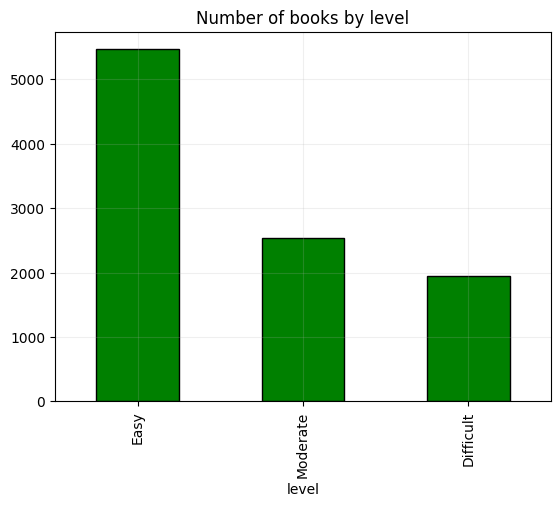

In [59]:
import matplotlib.pyplot as plt

description['level'].value_counts().plot(kind='bar', color='green', edgecolor='black', title="Number of books by level")
plt.grid(alpha=0.2)

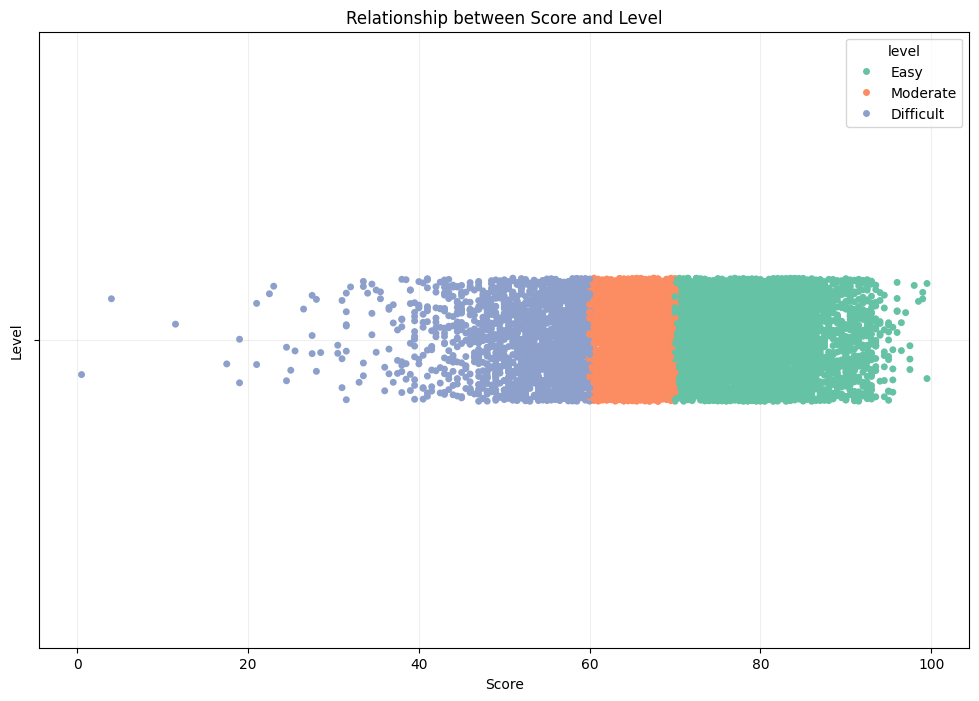

In [60]:
import seaborn as sns

plt.figure(figsize=(12, 8))
temp = description.dropna().copy()
sns.stripplot(data=temp, x=temp['score'], hue=temp['level'], palette='Set2')
plt.xlabel('Score')
plt.ylabel('Level')
# plt.legend('Level')
plt.title('Relationship between Score and Level')
plt.grid(alpha=0.2)
plt.show()

Tính toán các mốc ranh giới giữa các mức độ đọc.

In [61]:
# Compute score ranges for each class
class_ranges = temp.groupby('level')['score'].agg(['min', 'max']).sort_values('min')
print("Khoảng giá trị:\n", class_ranges)

# Compute boundaries between classes
boundaries = []
previous_max = None

for idx, row in class_ranges.iterrows():
    if previous_max is not None:
        # Boundary is the midpoint between the previous max and the current min
        boundary = (previous_max + row['min']) / 2
        boundaries.append(boundary)
    previous_max = row['max']

print("Giá trị của ranh giới:", boundaries)


Khoảng giá trị:
             min   max
level                
Difficult   0.5  60.0
Moderate   60.0  70.0
Easy       70.0  99.5
Giá trị của ranh giới: [60.0, 70.0]


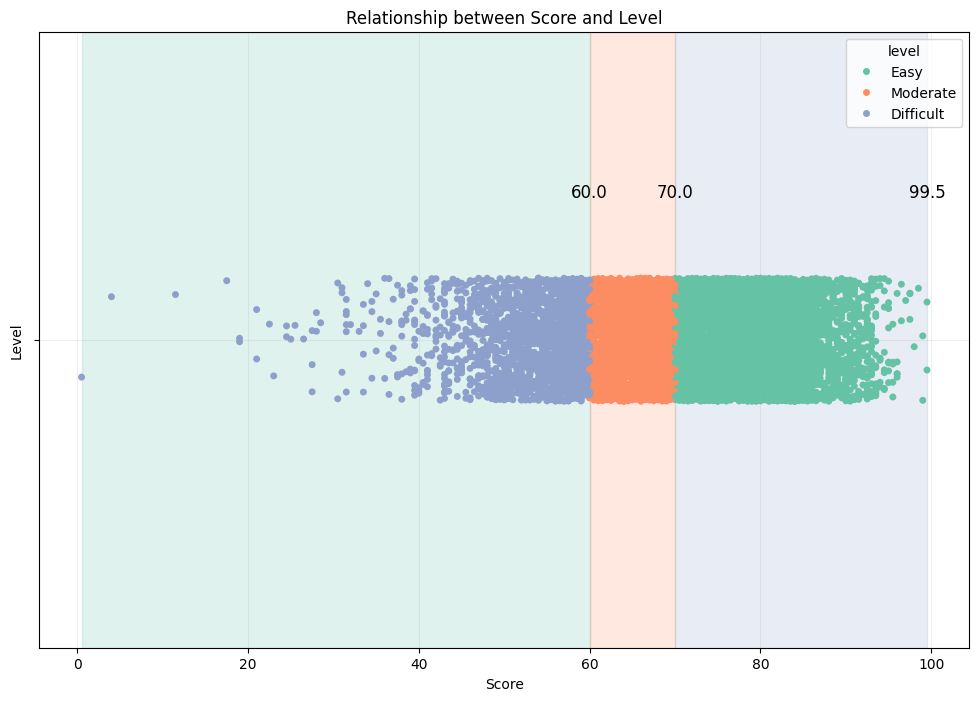

In [62]:
# Plot
plt.figure(figsize=(12, 8))
sns.stripplot(data=temp, x=temp['score'], hue=temp['level'], palette='Set2')
plt.xlabel('Score')
plt.ylabel('Level')
plt.title('Relationship between Score and Level')

colors = sns.color_palette("Set2", len(class_ranges))

# Add shaded regions between boundaries
start = class_ranges['min'].iloc[0]  # Start of the first class range
for i, boundary in enumerate(boundaries + [class_ranges['max'].iloc[-1]]):  # Include the last max as an endpoint
    plt.axvspan(start, boundary, color=colors[i], alpha=0.2)  # Add translucent shading
    midpoint = (start + boundary) / 2  # Điểm giữa ranh giới
    plt.text(boundary, plt.ylim()[1] * 0.45, f'{boundary}', 
             color='black', ha='center', va='bottom', fontsize=12)
    start = boundary  # Update start for the next region

# legend = plt.legend(title='Level', bbox_to_anchor=(1.05, 1), loc='upper left')
# legend_labels = {0: 'Easy', 1: 'Moderate', 2: 'Difficult'}  # Nhãn thay thế

# for text, original_label in zip(legend.get_texts(), sorted(temp['level'].unique())):
#     text.set_text(legend_labels[original_label])

plt.grid(alpha=0.2)
plt.show()


Ranh giới khá rõ ràng, có thể thấy biên giữa `Easy` và `Moderate` là 60 điểm, còn biên giữa `Moderate` và `Difficult` là 70 điểm.

# Data Model (Optional)

Trước hết, ta mã hoá các cột có giá trị dạng phân loại (categorical).

In [63]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = temp.select_dtypes(include=['object', 'category']).columns.tolist()

# Tạo encoder
encoder = LabelEncoder()

# Với mỗi cột có dữ liệu dạng categorical, ta tiến hành label encoding. 
# Nếu là cột target ta làm thêm một bước để lưu lại cách mapping từ tên -> số để tiện về sau
number_to_classname = {}
for column in categorical_columns:
    temp[column] = encoder.fit_transform(temp[column])
    if column == 'level':
        number_to_classname = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

In [64]:
number_to_classname

{0: 'Difficult', 1: 'Easy', 2: 'Moderate'}

Xem xét độ tương quan giữa các thuộc tính.

<Axes: >

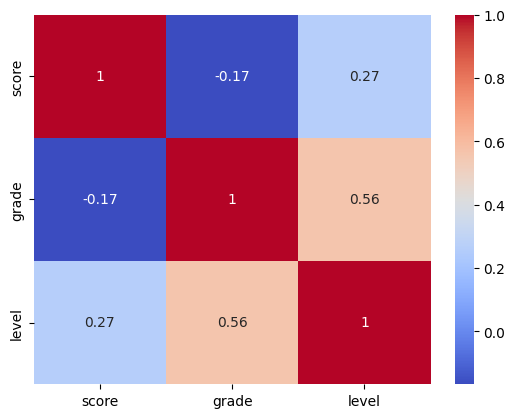

In [65]:
sns.heatmap(temp.corr(), annot=True, cmap='coolwarm')

### Hồi quy Logistic

Logistic Regression Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       581
           1       1.00      1.00      1.00      1613
           2       1.00      1.00      1.00       790

    accuracy                           1.00      2984
   macro avg       1.00      1.00      1.00      2984
weighted avg       1.00      1.00      1.00      2984



/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


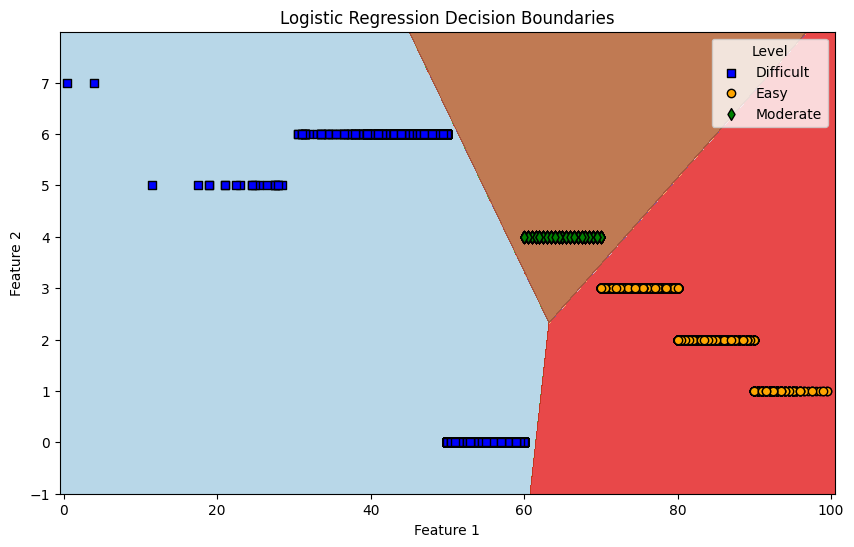

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


X = temp.drop(columns=["level"])
y = temp["level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

# Scale the features (optional for visualization but improves model performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = lr.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualization: Decision boundary
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict classifications for the mesh grid
Z = lr.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)

# Scatter plot the actual data points
for i, color, label, marker in zip([0, 1, 2], ['blue', 'orange', 'green'], encoder.classes_, ['s', 'o', 'd']):
    plt.scatter(X[y == i].iloc[:, 0], X[y == i].iloc[:, 1], c=color, label=label, edgecolor='k', marker=marker)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title="Level")
plt.title("Logistic Regression Decision Boundaries")
plt.show()

### KNN

KNN Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       581
           1       1.00      1.00      1.00      1613
           2       1.00      1.00      1.00       790

    accuracy                           1.00      2984
   macro avg       1.00      1.00      1.00      2984
weighted avg       1.00      1.00      1.00      2984



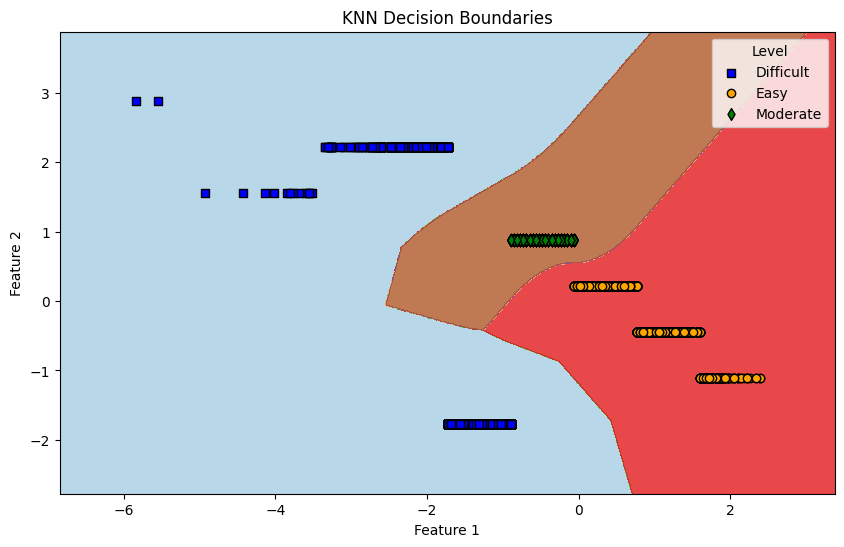

In [67]:
from sklearn.neighbors import KNeighborsClassifier

# Scale the features for better performance of KNN
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
print("KNN Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize the decision boundaries
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict classifications for the mesh grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)

# Scatter plot the actual data points
for i, color, label, marker in zip([0, 1, 2], ['blue', 'orange', 'green'], encoder.classes_, ['s', 'o', 'd']):
    plt.scatter(X_train_scaled[y_train == i, 0], X_train_scaled[y_train == i, 1],
                c=color, label=label, edgecolor='k', marker=marker)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title="Level")
plt.title("KNN Decision Boundaries")
plt.show()